## Understand and interpret vision models with Grad Cam

Gradient-weighted Class Activation Mapping, or Grad CAM, A technique for making Convolutional Neural Network (CNN)-based models more transparent by visualizing the regions of input that are “important” for predictions from these models — or visual explanations.

The idea is to base ourselves on the last convolution layer in the architecture and use the gradients calculated according to the value (or the a category) of the target variable in order to visualize the area of importance on the input.

Let us see how it works in practice using a pre-trained model.

In [2]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import inception_v3
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import requests
import os

The first step of Grad Cam is to train a convolutional neural network, or load a pre-trained network. We will focus on the last convolutional layer of the network, the one just before the flattenning of the outputs and the final prediction layers. We will base ourselves on this final convolutional layer to compute the Grad Cam.

We will also need an image input for the model to process in order to visualize on this image the regions of interest that the network will focus on to produce its prediction.

Let's go!

In [3]:
iv3 = inception_v3(pretrained=True)
from torchinfo import summary

# Print model summary
print(iv3)
summary(iv3, input_size=(1, 3, 299, 299))  # (batch_size, input_features)


/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

Layer (type:depth-idx)                   Output Shape              Param #
Inception3                               [1, 1000]                 3,326,696
├─BasicConv2d: 1-1                       [1, 32, 149, 149]         --
│    └─Conv2d: 2-1                       [1, 32, 149, 149]         864
│    └─BatchNorm2d: 2-2                  [1, 32, 149, 149]         64
├─BasicConv2d: 1-2                       [1, 32, 147, 147]         --
│    └─Conv2d: 2-3                       [1, 32, 147, 147]         9,216
│    └─BatchNorm2d: 2-4                  [1, 32, 147, 147]         64
├─BasicConv2d: 1-3                       [1, 64, 147, 147]         --
│    └─Conv2d: 2-5                       [1, 64, 147, 147]         18,432
│    └─BatchNorm2d: 2-6                  [1, 64, 147, 147]         128
├─MaxPool2d: 1-4                         [1, 64, 73, 73]           --
├─BasicConv2d: 1-5                       [1, 80, 73, 73]           --
│    └─Conv2d: 2-7                       [1, 80, 73, 73]           5,

We notice that the last convolutional layer (the last layer with "image-like" output) is layer InceptionE called `Mixed_7c`. This is the intermediate layer we'll target to compute grad cams.

First let's download an example image.

In [15]:
# Path to your .tgz file
os.makedirs("grad_cam/train",exist_ok=True)
file_path = "./grad_cam/train/elephant.jpg"

# Download and extract the dataset
url = 'https://full-stack-assets.s3.eu-west-3.amazonaws.com/Tanz-Great-Migration0042_reduced.jpg'
response = requests.get(url, stream=True)
with open(file_path, "wb") as file:
    for chunk in response.iter_content(chunk_size=1024):
        file.write(chunk)

Then apply transformations so it can work with our model.

In [18]:
# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((299, 299)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# define a 1 image dataset
dataset = datasets.ImageFolder(root='./grad_cam/', transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

We'll need the class labels in order to compare predictions with our expectations.

In [19]:
import requests
import json

LABELS_URL = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"

# Fetch JSON file from the URL
response = requests.get(LABELS_URL)

# Parse JSON content
imagenet_classes = response.json()

# Print first few class labels
print(imagenet_classes)  # Dictionary format: {'0': ['n01440764', 'tench'], '1': ['n01443537', 'goldfish'], ...}

# Convert into a dictionary of {class_idx: class_name}
class_labels = {int(k): v[1] for k, v in imagenet_classes.items()}

# Example: Get class name for index 207
print(class_labels[207])  # Output: 'golden_retriever'


{'0': ['n01440764', 'tench'], '1': ['n01443537', 'goldfish'], '2': ['n01484850', 'great_white_shark'], '3': ['n01491361', 'tiger_shark'], '4': ['n01494475', 'hammerhead'], '5': ['n01496331', 'electric_ray'], '6': ['n01498041', 'stingray'], '7': ['n01514668', 'cock'], '8': ['n01514859', 'hen'], '9': ['n01518878', 'ostrich'], '10': ['n01530575', 'brambling'], '11': ['n01531178', 'goldfinch'], '12': ['n01532829', 'house_finch'], '13': ['n01534433', 'junco'], '14': ['n01537544', 'indigo_bunting'], '15': ['n01558993', 'robin'], '16': ['n01560419', 'bulbul'], '17': ['n01580077', 'jay'], '18': ['n01582220', 'magpie'], '19': ['n01592084', 'chickadee'], '20': ['n01601694', 'water_ouzel'], '21': ['n01608432', 'kite'], '22': ['n01614925', 'bald_eagle'], '23': ['n01616318', 'vulture'], '24': ['n01622779', 'great_grey_owl'], '25': ['n01629819', 'European_fire_salamander'], '26': ['n01630670', 'common_newt'], '27': ['n01631663', 'eft'], '28': ['n01632458', 'spotted_salamander'], '29': ['n01632777', 

Now that we loaded the pre-trained model and downloaded an example input image let's dive into the Grad Cam details.

The idea will be to decompose the model in two parts:

* The first half of the model all the way to the last convolutional layer.
* The second half of the model, comprising all the layers after the last conv layer all the way until the prediction layer.

We will then use the method `register_forward_hook` from pytorch to get the outputs from an intermediate level, and `register_backward_hook`to get the gradients from that same indermediate layer.

We will compute the predictions of the model for the input image, and calculate gradients. Thanks to the defined hook, these will be computed for the target intermediate layer. Here we are not calculating the gradients of the parameters but those of the feature map itself, to measure the influence of each feature extracted from the image on the final prediction.

Both the output, and the gradient are tensors of shape (1, width, height, channels), where channels is the number of conv neurons on that last convolutional layer.

The gradient we just calculated has the same shape as the output, we will use it to evaluate the importance of each channel of our intermediate layer, therefore we compute the mean over each dimension but the channels to get the importance of each channel.

Each channel of the intermediate layer's output is multiplied by the channel importance we just calculated, and used to compute a weighted average of all the channels. This creates an object of shape (1, width, height, 1) that we will use as a heatmap to visualize on top of the input image after normalizing and resizing it to fit the input.

And, this, is a Grad Cam!

Don't worry if all this talking does not really makes sense right, you'll believe it when you see it!

Detected Class: African_elephant


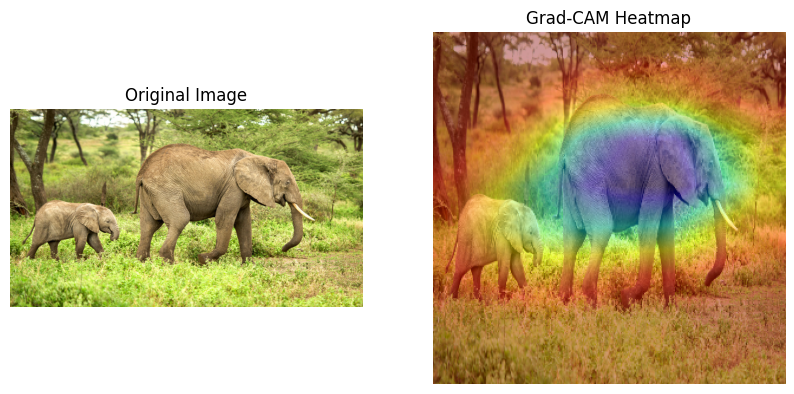

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1️⃣ Load the Pretrained InceptionV3 model
model = models.inception_v3(weights="IMAGENET1K_V1")
model.eval()  # Set to evaluation mode

# 2️⃣ Choose the target layer (the last convolutional layer)
target_layer = model.Mixed_7c

# 3️⃣ Preprocessing Function for Files
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((299, 299)),  # InceptionV3 expects 299x299 images
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# 4️⃣ Hook to Extract Gradients & Features
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.feature_maps = None
        self.class_idx = None

        # Register hooks for the intermediate layer
        self.target_layer.register_forward_hook(self.save_feature_maps)
        self.target_layer.register_full_backward_hook(self.save_gradients)

    def save_feature_maps(self, module, input, output):
        self.feature_maps = output  # Store forward pass output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]  # Store gradients

    def generate_heatmap(self, input_tensor):
        # Forward pass
        output = self.model(input_tensor)
        
        # If InceptionV3 has auxiliary outputs, take the main output
        if isinstance(output, tuple):
            output = output[0]

        # If no class is specified, take the top predicted class
        if self.class_idx is None:
            self.class_idx = torch.argmax(output).item()

        # Compute gradients for the target class
        self.model.zero_grad()
        output[:, self.class_idx].backward()

        # Compute importance weights (global average pooling of gradients)
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)

        # Compute weighted sum of feature maps
        grad_cam = torch.sum(weights * self.feature_maps, dim=1).squeeze().detach().numpy()

        # Apply ReLU (so negative values are ignored)
        grad_cam = np.maximum(grad_cam, 0)

        # Normalize to range [0, 1]
        grad_cam -= np.min(grad_cam)
        grad_cam /= np.max(grad_cam)

        return grad_cam

# 5️⃣ Function to Overlay Heatmap on Image or Tensor
def overlay_heatmap_on_image(image, heatmap):
    """ Overlay Grad-CAM heatmap on a PIL or OpenCV image """
    image = cv2.resize(image, (299, 299))  # Ensure correct size

    heatmap = cv2.resize(heatmap, (299, 299))
    heatmap = np.uint8(255 * heatmap)  # Convert to 8-bit

    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply colormap
    overlayed_img = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)

    return overlayed_img

# 6️⃣ Run Grad-CAM on an Image File
def run_grad_cam(image_path, class_labels):
    input_tensor = preprocess_image(image_path)
    grad_cam = GradCAM(model, target_layer)

    # Generate heatmap
    heatmap = grad_cam.generate_heatmap(input_tensor)

    # Read the original image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert OpenCV BGR to RGB

    # Overlay heatmap
    overlayed_img = overlay_heatmap_on_image(image, heatmap)

    # Show results
    print("Detected Class:", class_labels[grad_cam.class_idx])

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(overlayed_img)
    plt.axis("off")
    plt.title("Grad-CAM Heatmap")

    plt.show()

# 7️⃣ Run Grad-CAM on a Tensor
def run_grad_cam_on_tensor(input_tensor, class_labels, original_image):
    """ Applies Grad-CAM when input is a tensor instead of a file """
    grad_cam = GradCAM(model, target_layer)

    # Generate heatmap
    heatmap = grad_cam.generate_heatmap(input_tensor)

    # Convert tensor image back to NumPy
    image = original_image.numpy().transpose(1, 2, 0)  # Convert (C, H, W) -> (H, W, C)
    # Normalize to range [0, 1]
    image -= np.min(image)
    image /= np.max(image)
    image = (image * 255).astype(np.uint8)  # Convert to uint8 format

    # Overlay heatmap
    overlayed_img = overlay_heatmap_on_image(image, heatmap)

    # Show results
    print("Detected Class:", class_labels[grad_cam.class_idx])
 
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title("Original Image (Tensor)")

    plt.subplot(1, 2, 2)
    plt.imshow(overlayed_img)
    plt.axis("off")
    plt.title("Grad-CAM Heatmap")

    plt.show()

# 🔥 **Test with an Image**
image_path = "./grad_cam/train/elephant.jpg"  # Replace with your image path
run_grad_cam(image_path,class_labels=class_labels)


Impressive right? You can adapt this technique to other models and problems in order to understand what exactly in the input image helps your model make its predictions. This is very helpful because it will help you identify some biases in your images that would be very difficult to identify without this technique!